Digit Recognizer (MNIST)
=================================

This is an implementation of [Kaggle competition for recognizing digits](https://www.kaggle.com/c/digit-recognizer)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import ImageUtils
import DataUtils

## Loading the dataset

First let's investigate the training dataset, we first read the file, with seperater as `,` and specify that the first row is the header. We can then use the header as our dictionary key

In [11]:
train_data = pd.read_csv('train.csv', sep=',',header=0)
training_labels = train_data['label'].values
training_values = train_data.drop('label', 1).values

evaluation_data = pd.read_csv('test.csv', sep=',',header=0)
evaluation_values = evaluation_data.values

print("There are a total of {} training images".format(len(train_data)))
print("There are a total of {} evaluation images".format(len(evaluation_data)))

training_values = training_values/255
evaluation_values = evaluation_values/255

There are a total of 42000 training images
There are a total of 28000 evaluation images


## Dataset visualization

Now we try to investigate and print some of the data to understand the dataset, we start from index 0 and try every other image

The image is 1
The image is 0
The image is 7


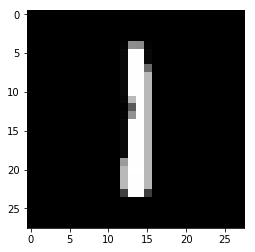

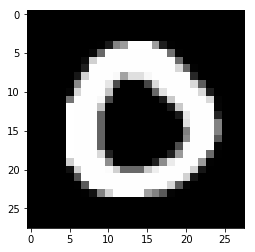

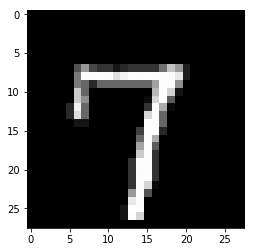

In [12]:
for x in range(2, 8, 2):
    row = DataUtils.reshape_row(training_values[x])
    ImageUtils.show_mnist_image(row)
    print("The image is {}".format(training_labels[x]))

Let's try visualizing the test dataset, we only have test dataset values, but no targets, which means we would have to split out training dataset into test dataset for training the neural network,

The reason why the Kaggel provided test dataset exists, is so that we run the test dataset through our neural network and output the values which would be checked against the test targets (that data is only with Kaggle)

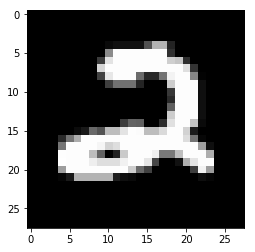

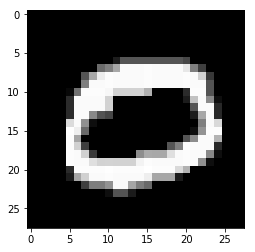

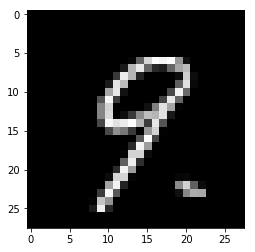

In [13]:
for x in range(0, 3):
    row = DataUtils.reshape_row(evaluation_values[x])
    ImageUtils.show_mnist_image(row)

## One hot encoding the targets

The output target is actual numerical values, so we would need to one hot encode the values

In [14]:
from keras.utils import to_categorical

print("Before one-hot encoding:\n {}".format(training_labels[:10]))

y_train = to_categorical(training_labels)

print("\n\nAfter one-hot encoding:\n {}".format(y_train[:10]))

Before one-hot encoding:
 [1 0 1 4 0 0 7 3 5 3]


After one-hot encoding:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Reshape input images

In [16]:
x_train = training_values.reshape(-1, 28, 28, 1)
print("Shape of training_values {}".format(x_train.shape))

Shape of training_values (42000, 28, 28, 1)


## Creating our Convolution Model

We would be using Keras Sequential layers to generate a model to fit the data

In [68]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, Callback

model = Sequential()

model.add(InputLayer(input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=5, strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Dropout(0.6))

model.add(Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 7, 7, 64)          0         
__________

In [71]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

checkpoint = ModelCheckpoint("./best.hdf5", monitor='val_acc', save_best_only=True,  mode='max')
history = LossHistory()

model.fit(x_train, y_train, validation_split=0.2, epochs=3, batch_size=64, \
        callbacks=[checkpoint, history])

Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 45s 1ms/step - loss: 0.3994 - acc: 0.8722 - val_loss: 0.2107 - val_acc: 0.9410
Epoch 2/3
33600/33600 [==============================] - 49s 1ms/step - loss: 0.3143 - acc: 0.9004 - val_loss: 0.1638 - val_acc: 0.9530
Epoch 3/3
33600/33600 [==============================] - 46s 1ms/step - loss: 0.2601 - acc: 0.9186 - val_loss: 0.1398 - val_acc: 0.9590


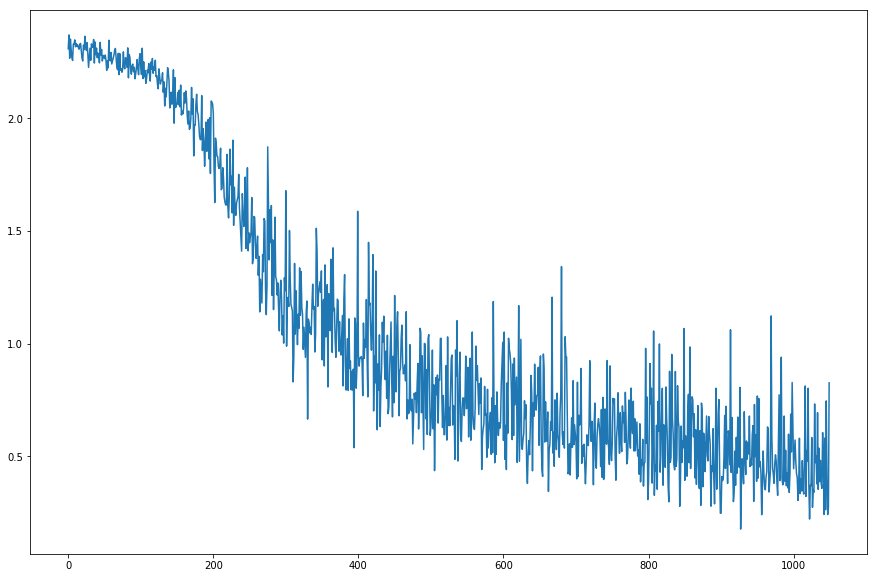

In [70]:
plt.figure(figsize=(15,10))
plt.plot(history.losses)

In [ ]:
x_evaluate = evaluation_values.reshape(-1, 28, 28, 1)
y_evaluate = model.predict(x_evaluate)
classes_evaluate = np.argmax(y_evaluate, axis=1)
print(classes_evaluate)